# Import Libraries

In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
from tqdm.notebook import tqdm

from skimage.transform import resize

# Function Definitions

In [2]:
def load_images(path):
    images = []
    filenames = os.listdir(path)

    for filename in tqdm(filenames):
        image = cv2.imread(os.path.join(path, filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        images.append(image)

    return np.array(images, dtype=object)

# Load Images

In [3]:
main_dir = './subsampled_fruits_dataset'
train_dir = f'{main_dir}/train'
classnames = ['freshapples', 'freshbanana', 'freshoranges',
              'rottenapples', 'rottenbanana', 'rottenoranges']
idx2class = {i: classname for i, classname in enumerate(classnames)}

class_0 = load_images(f'{train_dir}/freshapples')
class_1 = load_images(f'{train_dir}/freshbanana')
class_2 = load_images(f'{train_dir}/freshoranges')
class_3 = load_images(f'{train_dir}/rottenapples')
class_4 = load_images(f'{train_dir}/rottenbanana')
class_5 = load_images(f'{train_dir}/rottenoranges')

  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/395 [00:00<?, ?it/s]

  0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/585 [00:00<?, ?it/s]

  0%|          | 0/556 [00:00<?, ?it/s]

  0%|          | 0/398 [00:00<?, ?it/s]

# Plot Class Distribution

We can see that the classes are not balanced. We will need to take this into account when training and evaluating our model.

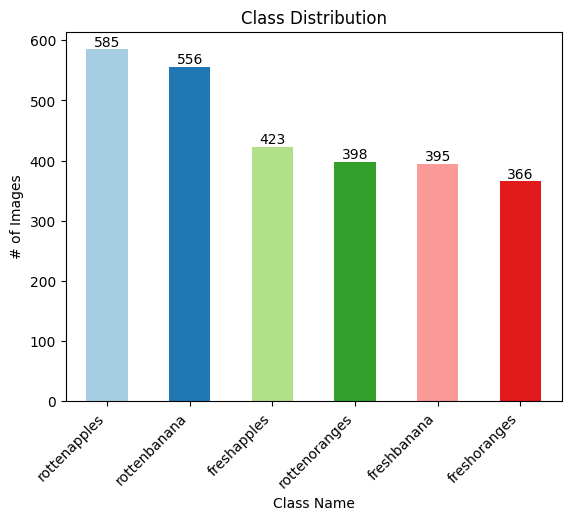

In [4]:
class_0_num_samples = len(class_0)
class_1_num_samples = len(class_1)
class_2_num_samples = len(class_2)
class_3_num_samples = len(class_3)
class_4_num_samples = len(class_4)
class_5_num_samples = len(class_5)

labels = np.array(
    [0] * class_0_num_samples +
    [1] * class_1_num_samples +
    [2] * class_2_num_samples +
    [3] * class_3_num_samples +
    [4] * class_4_num_samples +
    [5] * class_5_num_samples)

all_images = list(class_0) + list(class_1) + list(class_2) + \
    list(class_3) + list(class_4) + list(class_5)

df = pd.DataFrame(zip(all_images, labels), columns=['Image', 'Class'])
df['Class'] = df['Class'].map(idx2class)
bar = df['Class'].value_counts().plot(
    kind='bar', color=plt.get_cmap("Paired").colors,  # type: ignore
    title='Class Distribution',
    xlabel='Class Name',
    ylabel='# of Images')

plt.xticks(rotation=45, ha='right')

for p in bar.containers:  # type: ignore
    bar.bar_label(p, fmt='%d', label_type='edge')

In [5]:
def plot_images(images):
    plt.figure(figsize=(9, 9))

    for i, image in enumerate(images[0:25]):
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image)
        plt.suptitle("Original Dataset", fontsize=15)
    plt.show()

In [6]:
def segment_images(images):
    segmented_images = []
    for image in tqdm(images):

        # Convert to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # Blur the image
        blur_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

        # Apply Otsu thresholding to image
        ret, thresh = cv2.threshold(
            blur_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        # Apply mask on image
        segmented_image = cv2.bitwise_and(image, image, mask=thresh)
        segmented_images.append(segmented_image)
    
    return np.array(segmented_images, dtype=object)

In [7]:
segmented_images = segment_images(all_images)

  0%|          | 0/2723 [00:00<?, ?it/s]

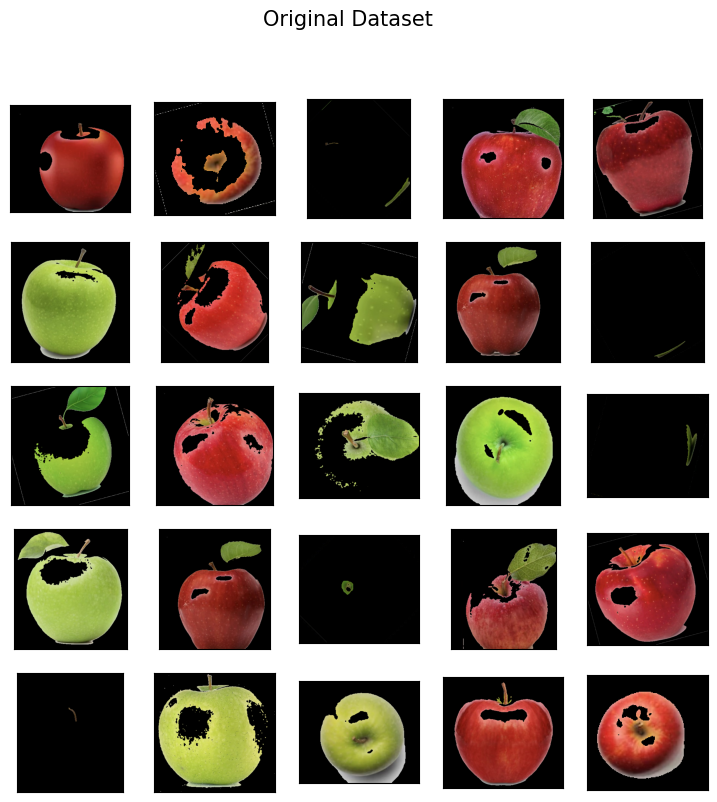

In [8]:
plot_images(segmented_images)

# Feature Extraction


In [13]:
def feature_extraction(img):
    red_mean, green_mean, blue_mean = np.mean(img, axis=(0, 1))
    red_std, green_std, blue_std = np.std(img, axis=(0, 1))

    red_skew = np.mean((img[:, :, 0] - red_mean)**3) / (red_std**3)
    green_skew = np.mean((img[:, :, 1] - green_mean)**3) / (green_std**3)
    blue_skew = np.mean((img[:, :, 2] - blue_mean)**3) / (blue_std**3)

    red_kurt = np.mean((img[:, :, 0] - red_mean)**4) / (red_std**4)
    green_kurt = np.mean((img[:, :, 1] - green_mean)**4) / (green_std**4)
    blue_kurt = np.mean((img[:, :, 2] - blue_mean)**4) / (blue_std**4)

    return [red_mean, green_mean, blue_mean, red_std, green_std, blue_std, red_skew, green_skew, blue_skew, red_kurt, green_kurt, blue_kurt]

In [14]:
columns = ['red_mean', 'green_mean', 'blue_mean', 'red_std', 'green_std', 'blue_std', 'red_skew', 'green_skew', 'blue_skew', 'red_kurt', 'green_kurt', 'blue_kurt']
df = pd.DataFrame(columns=columns)

for seg_image in tqdm(segmented_images):
    feature_vector = feature_extraction(seg_image)
    feature_vector = pd.Series(feature_vector, index=columns)
    df = pd.concat([df, feature_vector])

  0%|          | 0/2723 [00:00<?, ?it/s]

In [ ]:
df